In [5]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
from skimage import io
import cvlib as cv
from cvlib.object_detection import draw_bbox
from itertools import islice
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn import metrics
plt.style.use('ggplot')

In [6]:
train = pd.read_csv('train_bbox.csv')
image_num = 1111
image_id = train['ImageId'][image_num]
image = '../images/train_images/' + image_id + '.jpg'

# Box & Center

array([[2482, 1849, 2962, 2119],
       [2089, 1804, 2505, 2020],
       [3098, 1789, 3392, 1991],
       [ 769, 2366, 3191, 2692]])

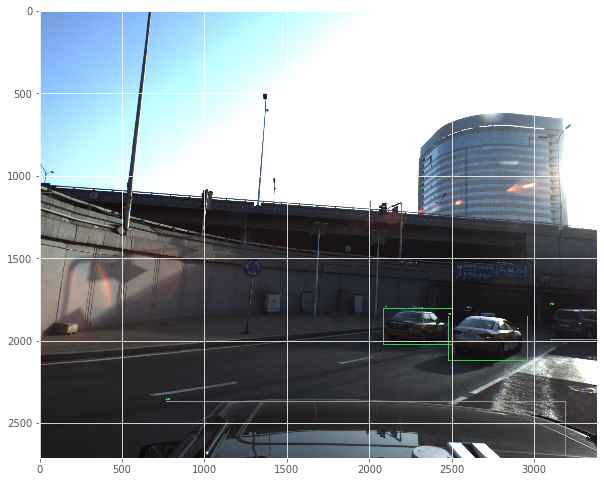

In [7]:
def find_cars(imageid):
    # Object Detection
    image = '../images/train_images/' + imageid + '.jpg'
    image_viz = io.imread(image)
    bbox, label, conf = cv.detect_common_objects(image_viz)
    
    # Select only cars
    cars = bbox, label, conf
    cars = [(bbox[n],label[n],conf[n]) for n in range(len(bbox)) if label[n] == 'car']
    cars = np.array(cars).transpose()
    output_image = draw_bbox(image_viz, cars[0], cars[1], cars[2])
    plt.figure(figsize=(10,10))
    plt.imshow(output_image)
    
    # Find centers
    bbox = np.array(bbox)
    if len(bbox) == 0:
        car_x = 0
        car_y = 0
    else:
        car_x = (bbox[:,0] + bbox[:,2]) / 2
        car_y = (bbox[:,1] + bbox[:,3]) / 2
#     plt.scatter(x = car_x, y = car_y, color='yellow', s=50)
#     plt.show()
    return bbox

image_num = 557
find_cars(image_id)

# Data

In [104]:
# INPUT
sample_size = 100

# Import
train_og = pd.read_csv('../data/train.csv')
train = pd.read_csv('train_bbox.csv')
#train = train.sample(sample_size)
#train['bbox'] = [find_cars(n) for n in train['ImageId']]
train = train.merge(train_og, on = 'ImageId')
train = train.drop(['Unnamed: 0', 'cars', 'PredictionString_x'], axis = 1)
train.columns = ['ImageId', 'bbox', 'PredictionString']
train['bbox'] = [x.replace('[','') for x in train['bbox']]
train['bbox'] = [x.replace(']','') for x in train['bbox']]
train['bbox'] = [x.replace('  ',' ') for x in train['bbox']]
train['bbox'] = [x.split('\n') for x in train['bbox']]
train['bbox'] = train.apply(lambda x : [i.split(' ') for i in x['bbox']], axis = 1)
train['bbox'] = train.apply(lambda x : [list(filter(None, i)) for i in x['bbox']], axis = 1)
train['bbox'] = train.apply(lambda x : [int(i) for b in x['bbox'] for i in b], axis = 1)
train['bbox'] = [list(chunk(x, 4)) for x in train['bbox']]

In [105]:
# Split Prediction String
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

#col_names = ['model', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']

train['PredictionString'] = [list(map(float, x)) for x in train['PredictionString'].str.split(" ")]
train['PredictionString'] = [list(chunk(x, 7)) for x in train['PredictionString']]
train['cars'] = [len(x) for x in train['PredictionString']]
# train

# Row per Car
per_car = pd.concat([train[['ImageId','cars','bbox']], train['PredictionString'].apply(pd.Series)], axis=1)
cols = [x for x in range(per_car['cars'].max())]
per_car = pd.melt(per_car, id_vars=['ImageId','cars','bbox'], value_vars=cols)
per_car = per_car.dropna(axis = 0)
per_car = per_car.drop('variable', axis = 1)
per_car = pd.concat([per_car[['ImageId', 'cars','bbox']], per_car['value'].apply(pd.Series)], axis = 1)
per_car.columns = ['ImageId', 'cars', 'bbox', 'model', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']

#camera matrix
fx = 2304.5479
fy = 2305.8757
cx = 1686.2379
cy = 1354.9849

camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

def xyz_to_xy(row):
    hc = np.dot(camera_matrix, np.array([row[7], row[8], row[9]]))
    xy = hc[:-1] / hc[-1]
    return np.int16(xy)

per_car['img_x'] = [xyz_to_xy(per_car.loc[n])[0] for n in per_car.index]
per_car['img_y'] = [xyz_to_xy(per_car.loc[n])[1] for n in per_car.index]

In [106]:
# Split Bbox
per_car['bbox'] = per_car.apply(lambda x : list(x['bbox']), axis = 1)
per_car['cars_detected'] = per_car.apply(lambda x : len(x['bbox']), axis = 1)
per_car = pd.concat([per_car[['ImageId','cars','model','yaw','pitch','roll','x','y','z','cars_detected','img_x','img_y']], per_car['bbox'].apply(pd.Series)], axis=1)
cols = [x for x in range(per_car['cars_detected'].max())]
per_car = pd.melt(per_car, id_vars=['ImageId','cars','model','yaw','pitch','roll','x','y','z','cars_detected', 'img_x','img_y'], value_vars=cols)
per_car = per_car.dropna(axis = 0)
per_car = per_car.drop('variable', axis = 1)
per_car = pd.concat([per_car[['ImageId','cars','model','yaw','pitch','roll','x','y','z','cars_detected', 'img_x','img_y']], per_car['value'].apply(pd.Series)], axis = 1)

In [107]:
per_car.columns = ['ImageId', 'cars', 'model', 'yaw', 'pitch', 'roll', 'x', 'y', 'z', 'cars_detected', 'img_x','img_y', 'box_x1', 'box_y1', 'box_x2', 'box_y2']
per_car['match'] = np.where((per_car['box_x1'] < per_car['img_x']) & (per_car['img_x'] < per_car['box_x2']) & (per_car['box_y1'] < per_car['img_y']) & (per_car['img_y'] < per_car['box_y2']), True, False)
per_car['width'] = per_car.apply(lambda x : x['box_x2'] - x['box_x1'], axis = 1)
per_car['height'] = per_car.apply(lambda x : x['box_y2'] - x['box_y1'], axis = 1)
per_car['yaw_class'] = pd.cut(per_car['pitch'], bins = 9, labels = False)

matches = per_car[per_car['match'] == True]

In [108]:
per_car.head()

,ImageId,cars,model,yaw,pitch,roll,x,y,z,cars_detected,img_x,img_y,box_x1,box_y1,box_x2,box_y2,match,width,height,yaw_class
0,ID_8a6e65317,5,16.0,0.254839,-2.575340,-3.10256,7.96539,3.20066,11.0225,6,3351,2024,607,1736,939,1932,False,332,196,0
1,ID_337ddc495,8,66.0,0.163988,0.192169,-3.12112,-3.17424,6.55331,31.4339,18,1453,1835,1379,1789,1549,1917,True,170,128,4
2,ID_a381bf4d0,25,43.0,0.162877,0.005193,-3.02676,2.18760,3.53427,13.3436,12,2064,1965,420,1796,1042,2122,False,622,326,4
3,ID_7c4a3e0aa,3,43.0,0.126957,-3.044420,-3.10883,-14.73800,24.63890,143.1300,3,1448,1751,1806,1532,2296,2040,False,490,508,0
4,ID_8b510fad6,19,37.0,0.160170,0.008628,-3.08870,-3.04548,3.49770,12.9646,10,1144,1977,852,1842,1354,2174,True,502,332,4


# Yaw Models

In [109]:
label = 'yaw_class'

box_yaw = matches[[label, 'box_x1', 'box_y1', 'width', 'height', 'model']]
y = box_yaw[label]
x = box_yaw.drop(label, axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

model = KNeighborsClassifier().fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.6306346381969158

In [110]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC(gamma='auto')))

# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.601806 (0.004908)
LDA: 0.598207 (0.004738)
KNN: 0.626939 (0.006554)
DT: 0.581412 (0.005916)
NB: 0.606735 (0.006082)


In [111]:
label = 'pitch'

box_yaw = matches[[label, 'box_x1', 'box_y1', 'width']]
y = box_yaw[label]
x = box_yaw.drop(label, axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

model = LinearRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.060915887773378
Mean Squared Error: 2.8652178040598475
Root Mean Squared Error: 1.6926954256628235


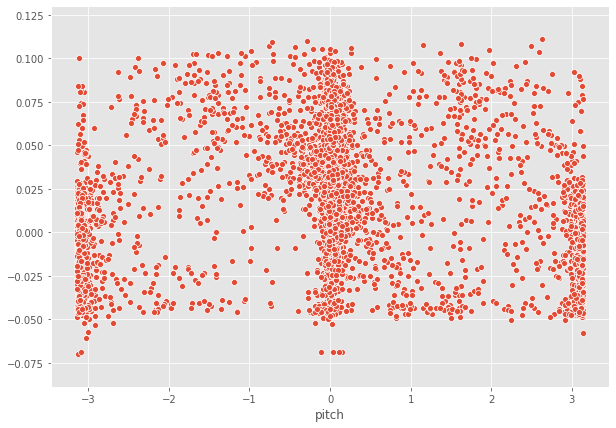

In [115]:
plt.figure(figsize = (10,7))
#sns.heatmap(box_yaw.corr(), annot = True)
sns.scatterplot(x = y_test, y = y_pred)

# 3D Box

In [152]:
car_models = pd.read_csv('../data/car-model-mapping.csv')
car_models

,model,id
0,"baojun-310-2017,",0
1,"biaozhi-3008,",1
2,"biaozhi-liangxiang,",2
3,"bieke-yinglang-XT,",3
4,"biyadi-2x-F0,",4
...,...,...
74,"changan-cs5,",74
75,"changcheng-H6-2016,",75
76,"dazhong-SUV,",76
77,"dongfeng-fengguang-S560,",77


In [ ]:
function [corners_2D,face_idx] = computeBox3D(object,P)
# takes an object and a projection matrix (P) and projects the 3D
# bounding box into the image plane.

# # index for 3D bounding box faces
# face_idx = [ 1,2,6,5   % front face
#              2,3,7,6   % left face
#              3,4,8,7   % back face
#              4,1,5,8]; % right face

# compute rotational matrix around yaw axis
R_y = np.array([[math.cos(theta[1]), 0, math.sin(yaw)], [0, 1, 0], [-math.sin(yaw), 0, math.cos(yaw)]


numpy.linalg.pinv                
#3D bounding box dimensions
h = 1.5
w = 1.7
l = 4.5

# 3D bounding box corners
x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
y_corners = [0,0,0,0,-h,-h,-h,-h]
z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]

# rotate and translate 3D bounding box
corners_3D = R_y * [x_corners, y_corners, z_corners]
corners_3D(1,:) = corners_3D(1,:) + object.t(1);
corners_3D(2,:) = corners_3D(2,:) + object.t(2);
corners_3D(3,:) = corners_3D(3,:) + object.t(3);

# project the 3D bounding box into the image plane
corners_2D = projectToImage(corners_3D, P);

In [ ]:
def euler_to_rot(yaw, pitch, roll) :
    R_x = np.array([[1, 0, 0], [0, math.cos(pitch), -math.sin(pitch)], [0, math.sin(pitch), math.cos(pitch)]                 
    R_y = np.array([[math.cos(theta[1]), 0, math.sin(yaw)], [0, 1, 0], [-math.sin(yaw), 0, math.cos(yaw)]
    R_z = np.array([[math.cos(roll), -math.sin(roll), 0], [math.sin(roll), math.cos(roll), 0], [0, 0, 1]]
    R = np.dot(R_z, np.dot( R_y, R_x )) 
    return R

array([[2482, 1849, 2962, 2119],
       [2089, 1804, 2505, 2020],
       [3098, 1789, 3392, 1991],
       [ 769, 2366, 3191, 2692]])

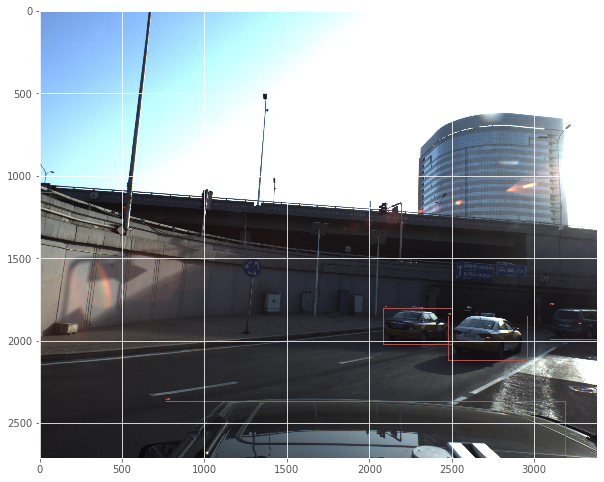

In [15]:
find_cars(image_id)

In [18]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[4][:2]), color, 16)

    cv2.line(image, tuple(points[1][:2]), tuple(points[5][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[6][:2]), color, 16)
    cv2.line(image, tuple(points[3][:2]), tuple(points[4][:2]), color, 16)
    cv2.line(image, tuple(points[3][:2]), tuple(points[7][:2]), color, 16)

    cv2.line(image, tuple(points[4][:2]), tuple(points[8][:2]), color, 16)
    cv2.line(image, tuple(points[5][:2]), tuple(points[8][:2]), color, 16)

    cv2.line(image, tuple(points[5][:2]), tuple(points[6][:2]), color, 16)
    cv2.line(image, tuple(points[6][:2]), tuple(points[7][:2]), color, 16)
    cv2.line(image, tuple(points[7][:2]), tuple(points[8][:2]), color, 16)
    return image

def draw_points(image, points):
    image = np.array(image)
    for (p_x, p_y, p_z) in points:
        # print("p_x, p_y", p_x, p_y)
        cv2.circle(image, (p_x, p_y), 5, (255, 0, 0), -1)
    return image

def img_cor_2_world_cor():
    x_img, y_img, z_img = img_cor_points[0]
    xc, yc, zc = x_img*z_img, y_img*z_img, z_img
    p_cam = np.array([xc, yc, zc])
    xw, yw, zw = np.dot(np.linalg.inv(k), p_cam)
    print(xw, yw, zw)
    print(x, y, z)

for yaw, pitch, roll, x, y, z in zip(yaws, pitches, rolls, xs, ys, zs):
    yaw, pitch, roll, x, y, z = [float(x) for x in [yaw, pitch, roll, x, y, z]]
    # I think the pitch and yaw should be exchanged
    yaw, pitch, roll = -pitch, -yaw, -roll
    Rt = np.eye(4)
    t = np.array([x, y, z])
    Rt[:3, 3] = t
    Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
    Rt = Rt[:3, :]
    P = np.array([[0, 0, 0, 1],
                  [x_l, y_l, -z_l, 1],
                  [x_l, y_l, z_l, 1],
                  [-x_l, y_l, z_l, 1],
                  [-x_l, y_l, -z_l, 1],
                  [x_l, -y_l, -z_l, 1],
                  [x_l, -y_l, z_l, 1],
                  [-x_l, -y_l, z_l, 1],
                  [-x_l, -y_l, -z_l, 1]]).T
    img_cor_points = np.dot(k, np.dot(Rt, P))
    img_cor_points = img_cor_points.T
    img_cor_points[:, 0] /= img_cor_points[:, 2]
    img_cor_points[:, 1] /= img_cor_points[:, 2]
    # call this function before chage the dtype
    img_cor_2_world_cor()
    img_cor_points = img_cor_points.astype(int)
    img = draw_points(img, img_cor_points)
    img = draw_line(img, img_cor_points)
    
img = Image.fromarray(img)
plt.imshow(img)
plt.show()

NameError: name 'yaws' is not defined